# 주식 시세 미래 예측

### 1. Prophet (오픈소스 기계학습 도구)
- 메타에서 공개한 시계열에 특화된 예측 라이브러리
- sklearn model의 API를 따름
- 이전 데이터를 학습 시킨 후 미래 데이터 예측     

* Prophet 인스턴스 입력 데이터프레임은 반드시 두 개의 컬럼(변수)를 가지고 있어야함
  - ds(DataStamp column): YYYY-MM-DD 또는 YYYY-MM-DD HH:MM:SS 형태의 시간
  - y : 예측하려는 측정 값 (숫자 유형이어야 함)

In [3]:
from prophet import Prophet # 기계학습 도구
import pandas as pd # 빅데이터 분석을 위해 사용하는 모듈
import requests # https 요청을 보내서 사이트에서 원하는 정보를 추출하기 위해 사용하는 모듈

1. 일일 주식 시세 정보 불러와서 저장하기

In [5]:
url = 'https://finance.naver.com/item/sise_day.naver?code=035720&page=' # 페이지 번호를 제외한 주소 저장
my_headers = {'user-agent' : 'Mozilla/5.0'} # 헤더 정보 설정

all_tables_year = pd.DataFrame() # 데이터를 축적할 데이터 프레임 생성

for page_number in range(1, 100):
  full_url = url + str(page_number) # 전체 주소 완성
  page = requests.get(full_url, headers = my_headers) # http 전송 후 응답 받아오기
  table = pd.read_html(page.text)[0] # 테이블 추출
  all_tables_year = pd.concat([all_tables_year, table]) # 데이터 프레임에 추가

all_tables_year.dropna(inplace=True) # 결측치 제거

2. Prophet 사용을 위해 ds(시간)와 y(예측 하려는 측정 숫자값) 컬럼(변수) 만듦

In [8]:
all_tables_year.rename(columns = {'날짜':'ds'}, inplace = True)
all_tables_year['y'] = all_tables_year['고가'] - ( (all_tables_year['고가'] - all_tables_year['저가'])/2 ) # 중위값 컬럼 y 추가

all_tables_year

,ds,종가,전일비,시가,고가,저가,거래량,y
1,2023.11.22,50300.0,1050.0,48750.0,51000.0,48250.0,2451691.0,49625.0
2,2023.11.21,49250.0,1450.0,48300.0,49600.0,48300.0,2483017.0,48950.0
3,2023.11.20,47800.0,300.0,47250.0,48150.0,47000.0,929546.0,47575.0
4,2023.11.17,47500.0,700.0,48150.0,48150.0,47200.0,1144308.0,47675.0
5,2023.11.16,48200.0,100.0,47400.0,48250.0,46850.0,1565115.0,47550.0
...,...,...,...,...,...,...,...,...
9,2019.11.26,157500.0,1000.0,157000.0,158500.0,156500.0,361401.0,157500.0
10,2019.11.25,156500.0,3500.0,153500.0,156500.0,153500.0,300270.0,155000.0
11,2019.11.22,153000.0,1000.0,153000.0,155500.0,152000.0,335038.0,153750.0
12,2019.11.21,154000.0,2500.0,156500.0,157000.0,151000.0,666854.0,154000.0


3. 최종 입력 데이터프레임 준비

In [20]:
df = pd.DataFrame() # 학습 대상 데이터프레임 생성
df = all_tables_year[['ds', 'y']] # 필요한 컬럼(변수) ds와 y만 추출하여 저장
df2 = df.query('ds > "2021-01-01"')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      714 non-null    object 
 1   y       714 non-null    float64
dtypes: float64(1), object(1)
memory usage: 16.7+ KB


4. 데이터 학습

In [21]:
model = Prophet() # Prophet 모델 객체 인스턴스 생성
model.fit(df2) # 훈련 데이터(데이터프레임)로 학습하여 prophet 모델 만들기

future = model.make_future_dataframe(periods=365) # 예측 결과를 저장할 데이터 프레임 준비 (향후 365일치 예측 값 세팅)
future.info() # 714 + 365 = 1079개의 데이터 프레임

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdy7m01ix/telgnx79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdy7m01ix/7a47dejv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62806', 'data', 'file=/tmp/tmpdy7m01ix/telgnx79.json', 'init=/tmp/tmpdy7m01ix/7a47dejv.json', 'output', 'file=/tmp/tmpdy7m01ix/prophet_modeld_5q4wvf/prophet_model-20231122145154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:51:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1079 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 8.6 KB


5. 데이터 예측 및 시각화

In [22]:
forecast = model.predict(future) # 365일치의 데이터 예측

forecast.head()
# ds : 예측한 날짜/시간
# yhat : 모델이 예측한 값
# yhat_lower, yhat_upper : 예측 값의 신뢰구간을 나타내는 하한(예측 최소값)과 상한(예측 최대값) 값
# weekly : 주 단위 추세를 나타내는 컬럼

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,487404.056000,431171.818982,540845.138942,487404.056000,487404.056000,-2580.229355,-2580.229355,-2580.229355,17084.478918,17084.478918,17084.478918,-19664.708273,-19664.708273,-19664.708273,0.0,0.0,0.0,484823.826645
1,2021-01-05,485188.718395,428854.207889,536463.901553,485188.718395,485188.718395,-468.281044,-468.281044,-468.281044,19343.356626,19343.356626,19343.356626,-19811.637670,-19811.637670,-19811.637670,0.0,0.0,0.0,484720.437351
2,2021-01-06,482973.380791,432133.544120,537181.220281,482973.380791,482973.380791,1813.498802,1813.498802,1813.498802,21623.423947,21623.423947,21623.423947,-19809.925144,-19809.925144,-19809.925144,0.0,0.0,0.0,484786.879593
3,2021-01-07,480758.043186,426890.692293,531770.425347,480758.043186,480758.043186,1207.005394,1207.005394,1207.005394,20879.128840,20879.128840,20879.128840,-19672.123446,-19672.123446,-19672.123446,0.0,0.0,0.0,481965.048581
4,2021-01-08,478542.705582,427454.218998,532804.265798,478542.705582,478542.705582,1668.591295,1668.591295,1668.591295,21081.230868,21081.230868,21081.230868,-19412.639573,-19412.639573,-19412.639573,0.0,0.0,0.0,480211.296877


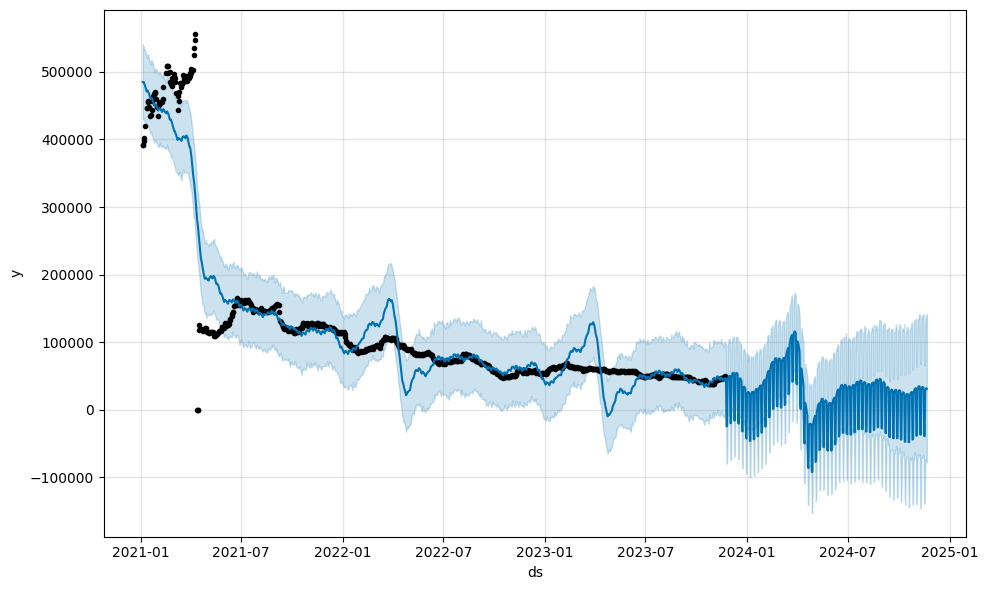

In [23]:
# 단순 그래프로 시각화
fig1 = model.plot(forecast)
# 검정색 선 : 실제 데이터 컬럼
# 파란색 선 : 모델이 예측한 값 컬럼
# 학습 데이터의 변동폭이 크면, 예측 값의 최대, 최소 값이 크다.

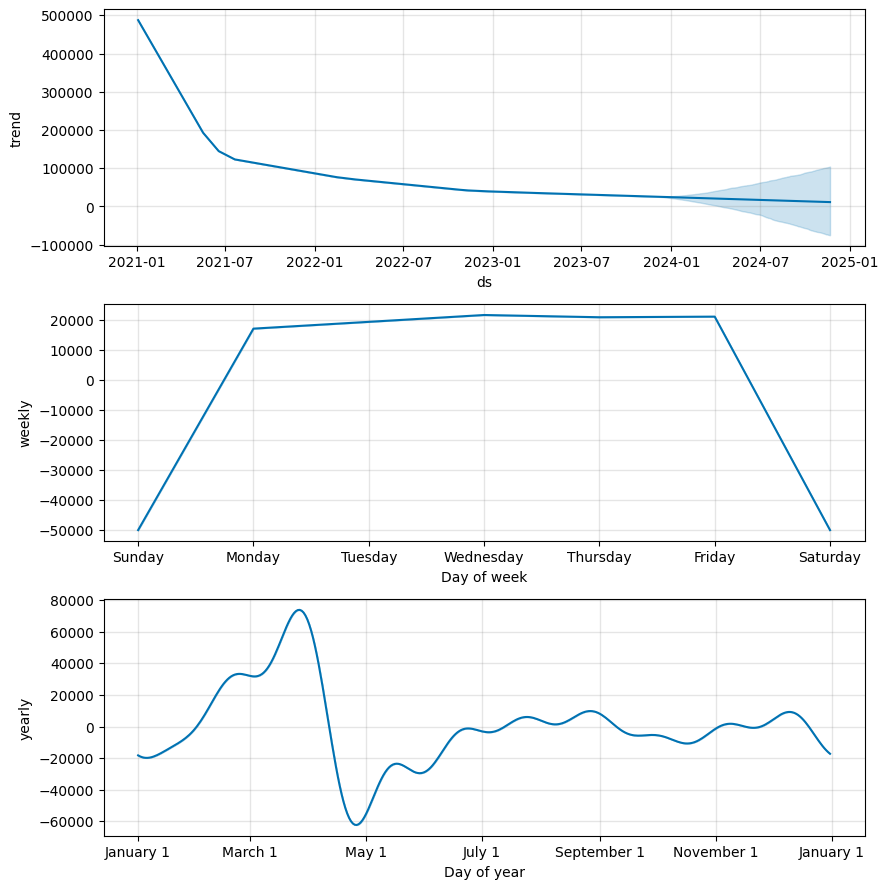

In [24]:
# 예측 컴포넌트 확인
fig2 = model.plot_components(forecast)
# 1번 그래프 : 학습한 데이터와 예측한 데이터의 전반적인 흐름
# 2번 그래프 : 학습한 데이터의 주 단위 데이터 흐름
# 3번 그래프 : 학습한 데이터의 월 단위 데이터 흐름

6. 대화형 그래프
- 기간을 변경하면서 특정 구간을 자세히 보고싶을 때
- plotly 모듈 사용 (Prophet 설치 시 자동으로 설치됨)
- prophet 설치해야함

In [26]:
from prophet.plot import plot_plotly, plot_components_plotly

import plotly.offline as pyo
pyo.init_notebook_mode(connected = True) # Plotly 그래프를 인라인으로 표시

plot_plotly(model, forecast) # 대화형 예측 그래프 그리기

In [27]:
# 대화형 예측 컴포넌트 그리기
plot_components_plotly(model, forecast)